In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve
from scipy.signal import find_peaks
from scipy.optimize import curve_fit



# import lightkurve as lk
# from scipy.optimize import curve_fit

# from astropy.convolution import Gaussian1DKernel
# from astropy.convolution import convolve
sys.path.insert(0, "../")

from michael import janet

Hi there. Welcome to the good place.


In [2]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

Index 258 is a good tester. Clear rotational signal, ambiguous peak mode.

Already have data downloaded for Gaia ID 1923544057484996224.
If you want to check for new data, run `janet.update()`.
### Running Simple Astropy Lomb-Scargle on Sector 16 on star 1923544057484996224 ###
### Completed Simple Astropy Lomb-Scargle for Sector 16 on star 1923544057484996224 ###
### Saved results ###
### Running Wavelet Estimation for Sector 16 on star 1923544057484996224 ###


/Users/Anaconda/anaconda3/envs/michael/lib/python3.8/site-packages/jazz_hands-0.0.3-py3.8.egg/jazzhands/wavelets.py:488: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/74 [00:00<?, ?it/s]

### Completed Wavelet Estimation for Sector 16 on star 1923544057484996224 ###
### Saved results ###
### Running Composite ACF estimation for Sector 16 on star 1923544057484996224 ###
### Completed Composite ACF estimation for Sector 16 on star 1923544057484996224 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector 17 on star 1923544057484996224 ###
### Completed Simple Astropy Lomb-Scargle for Sector 17 on star 1923544057484996224 ###
### Saved results ###
### Running Wavelet Estimation for Sector 17 on star 1923544057484996224 ###


  0%|          | 0/74 [00:00<?, ?it/s]

### Completed Wavelet Estimation for Sector 17 on star 1923544057484996224 ###
### Saved results ###
### Running Composite ACF estimation for Sector 17 on star 1923544057484996224 ###
### Completed Composite ACF estimation for Sector 17 on star 1923544057484996224 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector all on star 1923544057484996224 ###
### Completed Simple Astropy Lomb-Scargle for Sector all on star 1923544057484996224 ###
### Saved results ###
### Running Wavelet Estimation for Sector all on star 1923544057484996224 ###


  0%|          | 0/151 [00:00<?, ?it/s]

### Completed Wavelet Estimation for Sector all on star 1923544057484996224 ###
### Saved results ###
### Running Composite ACF estimation for Sector all on star 1923544057484996224 ###
### Completed Composite ACF estimation for Sector all on star 1923544057484996224 ###
### Saved results ###
### Running ACF Estimation on star 1923544057484996224 ###
### Completed ACF Estimation on star 1923544057484996224 ###
### Saved results ###
### Saved results ###
### Saved results ###
### Saved results ###
### Saved results ###
### Saved results ###
### Saved results ###


/Users/oliver hall/Research/michael/Examples/../michael/validate.py:173: UserWarning: One or more sectors disagree strongly across all estimates. Please inspect the results carefully yourself.
  warnings.warn("One or more sectors disagree strongly across all estimates. Please inspect the results carefully yourself.")



------ Decoding Overall Period Flag 641 ------
512: One or more sectors disagrees strongly across all estimates with the others. This may indicate signal from a background star present in those sectors.
128: The ACF period does not match the 'best' period within 2 sigma.
1: Best rotation is from the Simple Lomb Scargle (SLS) method.

No other flags raised. 

### Saved results ###


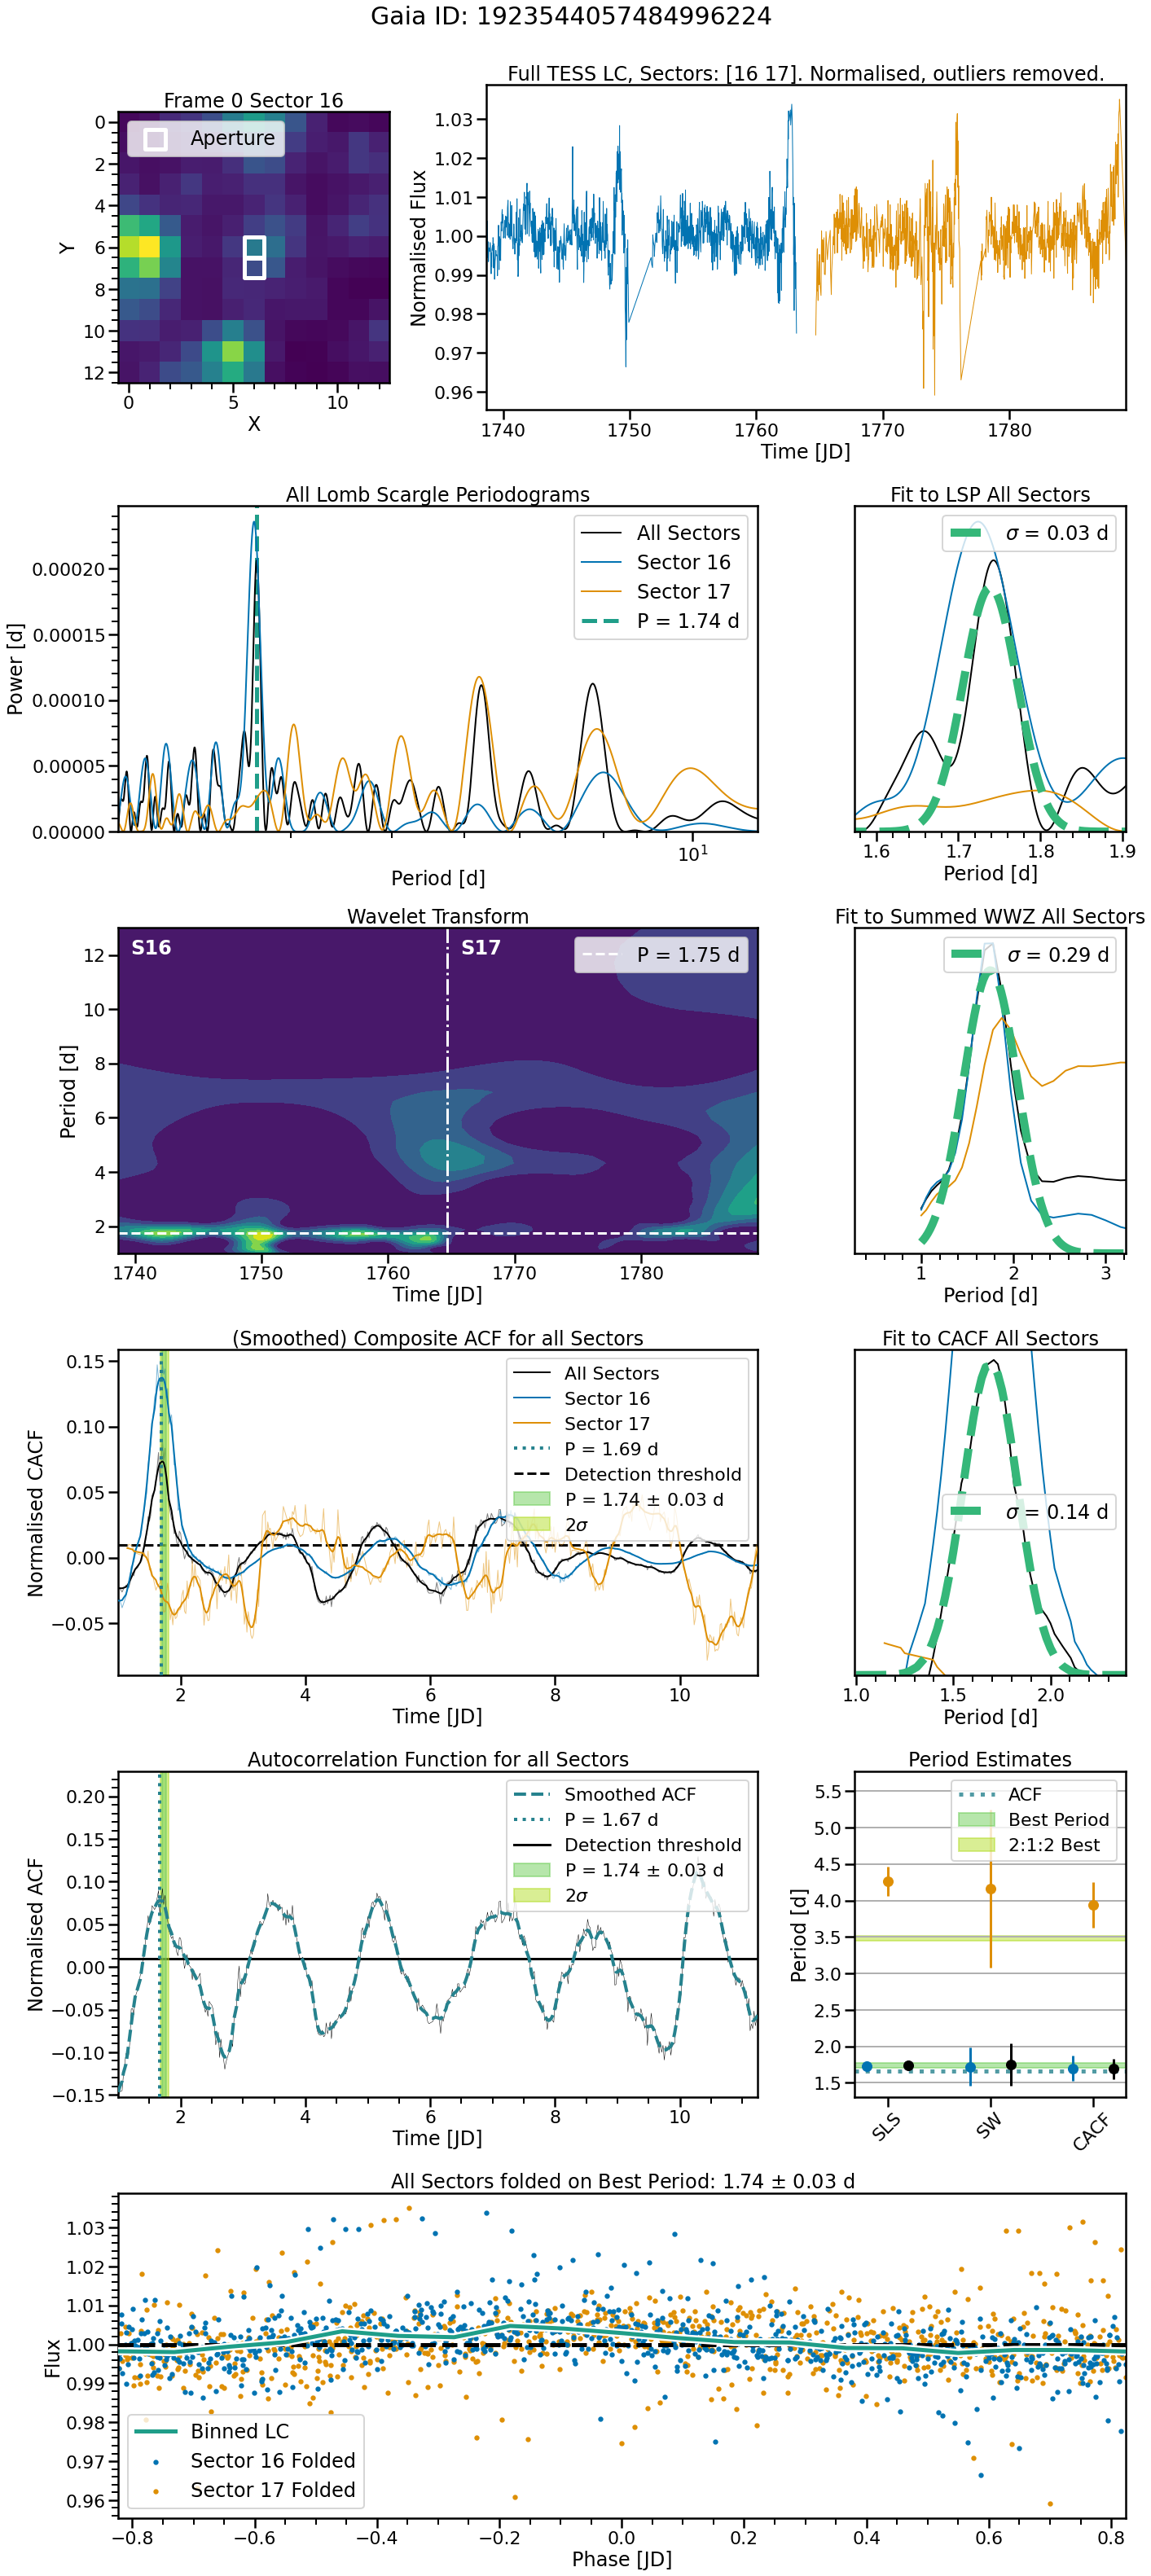

In [3]:
j = janet.boot(uni, index=258)
j.run(period_range = (1., 13.))